# Algorithms 202: Coursework 2 Task 1: Random Sampling

Author: Jin Ha

## Objectives

The aim of this coursework is to enhance your algorithmic skills by developing algorithms from textual, non-formal descriptions. You are asked to show that you can:

- implement three different random sampling algorithms
- compare those algorithms using visual representations based on image sampling

This notebook *is* the coursework. It contains cells with function definitions that you will need to complete. You will submit this notebook as your coursework.

## Preliminaries: helper functions

Here we define a collection of functions that will be useful for the rest of the coursework. You'll need to run this cell to get started.

In [1]:
%matplotlib inline

import numpy as np

from math import sqrt, pi, sin, cos, ceil, pow
from random import random, randint

from scipy.ndimage import map_coordinates
from scipy.spatial import cKDTree as KDTree
from matplotlib import pyplot as plt
from PIL import Image

def load_image(path):
    return np.array(Image.open(str(path)))

def sample_colors(image, sample_points):
    r"""
    Sample RGB colour values from an image of shape (w, h, 3)
    at floating point (x, y) sample points.
    """
    r = map_coordinates(image[..., 0], sample_points.T)
    g = map_coordinates(image[..., 1], sample_points.T)
    b = map_coordinates(image[..., 2], sample_points.T)
    return np.vstack((r, g, b)).T

def indices_of_pixels(image):
    r"""(x, y) index values for each pixel in an image.
    """
    return np.indices(image.shape[:2]).reshape([2, -1]).T

def closest_index(sample_points, indices):
    r"""
    Find the nearest sample_point at a given index
    (along with the distance to the point). Input is
    an array of sample_points and an array of indicies to
    test at. Output is array of indices and distances.
    """
    kdtree = KDTree(sample_points)
    distance, index = kdtree.query(indices)
    return index, distance

def resample_image(image, sample_points):
    # for each (floating point) sample_point extract the
    # RGB colour value of the image at that location
    colors = sample_colors(image, sample_points)
    # get all (x, y) index values for each pixel in
    # the image
    indices = indices_of_pixels(image)
    # for every pixel (each index) find the nearest sample
    # point (and the distance, but we don't need it here)
    c_index,_ = closest_index(sample_points, indices)
    # map the closest indexes to colour values - reshape
    # the resulting RGB array back into the original image 
    # shape.
    return colors[c_index].reshape(image.shape)

## Task 1: Random Sampling

In this task you are asked to implement `uniform_sampling`, `best_candidate_sampling` and `poison_disc_sampling`. Additionally, you will need to implement visualising techniques that can be used to compare the output of the three different random sampling algorithms.

Complete the below function definitions in the provided skeleton code. Do not change the names of the functions or their arguments.

### 1a. Implement `uniform_sampling`

The `uniform_sampling` function should produce `n_samples` sample points randomly distributed over the sample domain. See lecture slides for details and pseudo-code. Hint: The sample domain defined by the width and the height of the image can be obtained by `image.shape[:2]`.

In [2]:
def uniform_sampling(image, n_samples):
    
    # retrieve width and height of the input image
    (w, h) = image.shape[:2]
    
    # create lists, samples that contains co-ordinates of x and y respectively
    samples = []
    
    # for n_samples times, each iteration generates one tuple of (x, y) that is, a random sample
    for i in range(n_samples):
        
        sample = uniform_sample(w, h)
        samples.insert(i, sample)
        
    return np.array(samples)

def uniform_sample(width, height):
    x = random() * width
    y = random() * height
    
    return (x, y)


### 1b. Implement `best_candidate_sampling`

The `best_candidate_sampling` function should produce `n_samples` sample points randomly distributed over the sample domain. See lecture slides for details and pseudo-code. Hint: The `best_candidate` function here corresponds to the BEST-CANDIDATE-SAMPLE function in the slides, which generates a single new sample.

In [3]:
def best_candidate_sampling(image, n_samples, n_candidates):
    
    # retrieve width and height of the input image
    (w, h) = image.shape[:2]
    
    # create a first element by uniform_sample
    (a, b) = uniform_sample(w, h)
    
    # create a list of samples containing an co-ordinate
    samples = [(a, b)]
    
    # iterate it for n_samples times - 1, each iteration gives a random sample, (x, y)
    for i in range(1, n_samples):
        
        (x, y) = best_candidate(image, samples, n_candidates)
        
        # update samples list that will be used for next iteration onwards
        samples.insert(i, (x, y))
        
    return np.array(samples)

def best_candidate(image, samples, n_candidates):
    best_candidate = (0, 0)
    best_distance = 0
    
    (w, h) = image.shape[:2]
    
    for i in range(n_candidates):
        c = uniform_sample(w, h)
        d = distance(find_closest(samples, c), c)
        if d > best_distance:
            best_distance = d
            best_candidate = c

    return best_candidate

def find_closest(samples, c):
    best_candidate = samples[0]
    best_distance = distance(best_candidate, c)
    
    for i in range(1, len(samples)):
        
        current_distance = distance(samples[i], c)
        
        if current_distance < best_distance:
            best_distance = current_distance
            best_candidate = samples[i]

    return best_candidate

def distance(x, y):
    dx = x[0] - y[0]
    dy = x[1] - y[1]
    
    return sqrt(dx * dx + dy * dy)


### 1c. Implement `poison_disc_sampling`

The `poison_disc_sampling` function should produce sample points randomly distributed over the sample domain with a minimum distance of `radius`. See lecture slides and [Bridson's original paper](https://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf) for details.

In [4]:
def poison_disc_sampling(image, radius, n_candidates):
    cell_size = radius / sqrt(2)
    
    (w, h) = ceil(image.shape[0] / cell_size), ceil(image.shape[1] / cell_size)
    
    grid = []
    
    for i in range(w):
        grid.append([-1] * h)
    
    initial_point = uniform_sample(w, h)
    
    active_list = [initial_point]
    sample_list = [initial_point]
    
    grid = grid_insert(grid, initial_point, cell_size)

    while len(active_list) != 0:
        index = randint(0, len(active_list) - 1)
        point = active_list.pop(index)
        
        for i in range(n_candidates):
            new_point = generate_random_point(image, point, radius)
            
            if is_in_grid(new_point, radius, grid):
                grid_insert(grid, new_point, cell_size)
                active_list.append(new_point)
                sample_list.append(new_point)
    
    return np.array(sample_list)

def image_to_grid(point, cell_size):
    x = int(point[0] / cell_size)
    y = int(point[1] / cell_size)
    
    return (x, y)

def grid_insert(grid, point, cell_size):
    p = image_to_grid(point, cell_size)
    grid[p[0]][p[1]] = point
    
    return grid

def generate_random_point(image, point, radius):
    (w, h) = image.shape[:2]
    
    active_radius = radius * (random() + 1)
    theta = 2 * pi * random()
    
    x = int(active_radius * cos(theta) + point[0])
    y = int(active_radius * sin(theta) + point[1])
    
    if x >= 0 and y >= 0 and x < w and y < h:
        point = (x, y)
    
    return point

def is_in_grid(point, radius, grid):
    for i in grid:
        for p in i:
            if p != -1:
                if distance(p, point) < radius:
                    return False
    return True

def distance(first, second):
    return sqrt(pow(first[0] - second[0], 2) + pow(first[1] - second[1], 2))


### Image sampling

The following cells are for testing and visualisation of your sampling methods.

#### Load test image

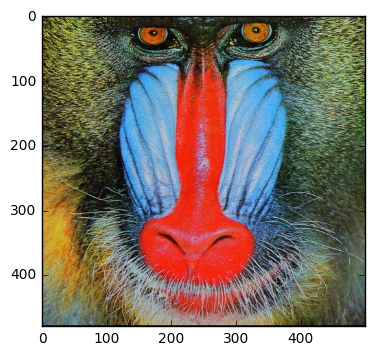

In [5]:
#image= load_image('./images/brain.png')
#image = load_image('./images/face.png')
#image = load_image('./images/lighthouse.png')
image = load_image('./images/mandrill.png')
#image = load_image('./images/parrots.png')
#image = load_image('./images/starry-night.png')
#image = load_image('./images/synth.png')
plt.imshow(image)

#### Generate random samples

In [6]:
#less samples - good for debugging
samples_uni = uniform_sampling(image, 685)
samples_bc = best_candidate_sampling(image, 685, 10)
samples_pd = poison_disc_sampling(image, 15, 30)

#more samples - looks better
#samples_uni = uniform_sampling(image, 2000)
#samples_bc = best_candidate_sampling(image, 2000, 10)
#samples_pd = poison_disc_sampling(image, 10, 30)

#### Plot samples

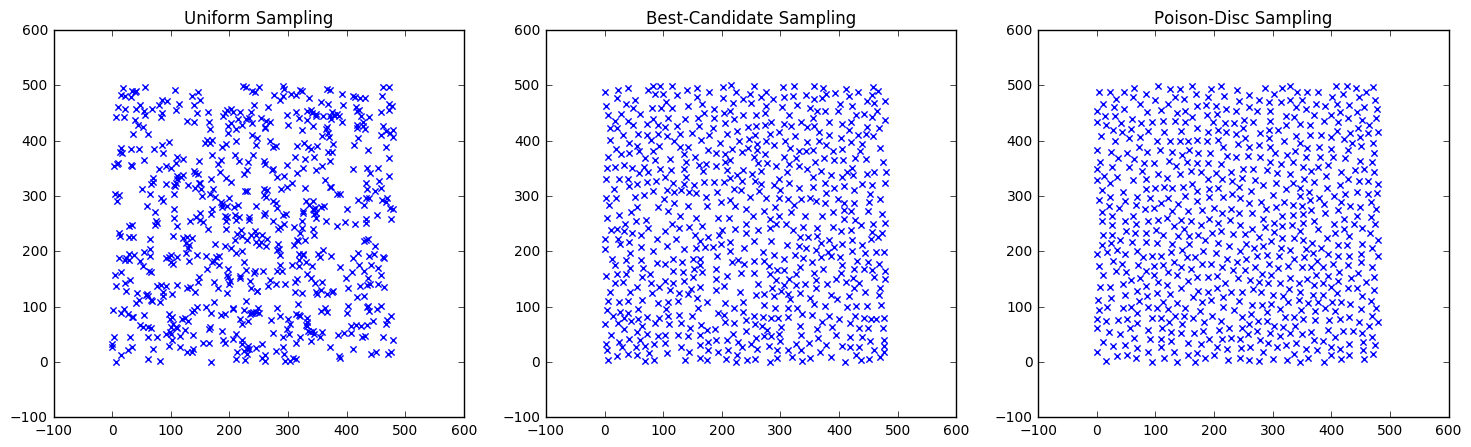

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))
axs[0].scatter(samples_uni[:,0], samples_uni[:,1], marker='x')
axs[0].set_title('Uniform Sampling')
axs[1].scatter(samples_bc[:,0], samples_bc[:,1], marker='x')
axs[1].set_title('Best-Candidate Sampling')
axs[2].scatter(samples_pd[:,0], samples_pd[:,1], marker='x')
axs[2].set_title('Poison-Disc Sampling')
plt.show()

#### Resample images using random samples

In [8]:
image_uni = resample_image(image, samples_uni)
image_bc = resample_image(image, samples_bc)
image_pd = resample_image(image, samples_pd)

#### Plot images

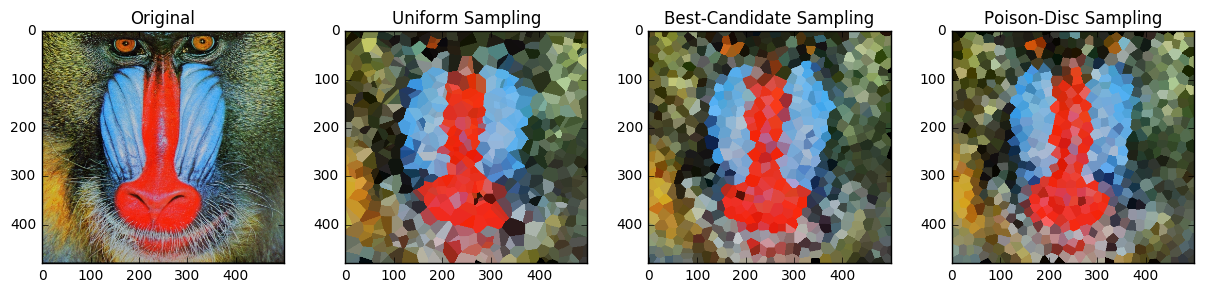

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(15,3))
axs[0].imshow(image)
axs[0].set_title('Original')
axs[1].imshow(image_uni)
axs[1].set_title('Uniform Sampling')
axs[2].imshow(image_bc)
axs[2].set_title('Best-Candidate Sampling')
axs[3].imshow(image_pd)
axs[3].set_title('Poison-Disc Sampling')
plt.show()

### 1d. Implement `distance_map` for colouring image points according to their distance to sample points

The `distance_map` function should generate an image where each pixel intensity is set to the distance to the closest sample point. Hint: You might want to check out the `resample_image` function provided above for guidance.

In [10]:
def distance_map(image, sample_points):
    (_, distance)= closest_index(sample_points, indices_of_pixels(image))
    return generate_color(distance).reshape(image.shape)

def generate_color(distance):
    rgb = []
    for i in distance:
        rgb.append((i, i, i))
    return np.array(rgb)


#### Generate distance maps using random samples

In [11]:
distmap_uni = distance_map(image, samples_uni)
distmap_bc  = distance_map(image, samples_bc)
distmap_pd  = distance_map(image, samples_pd)

#### Plot distance maps

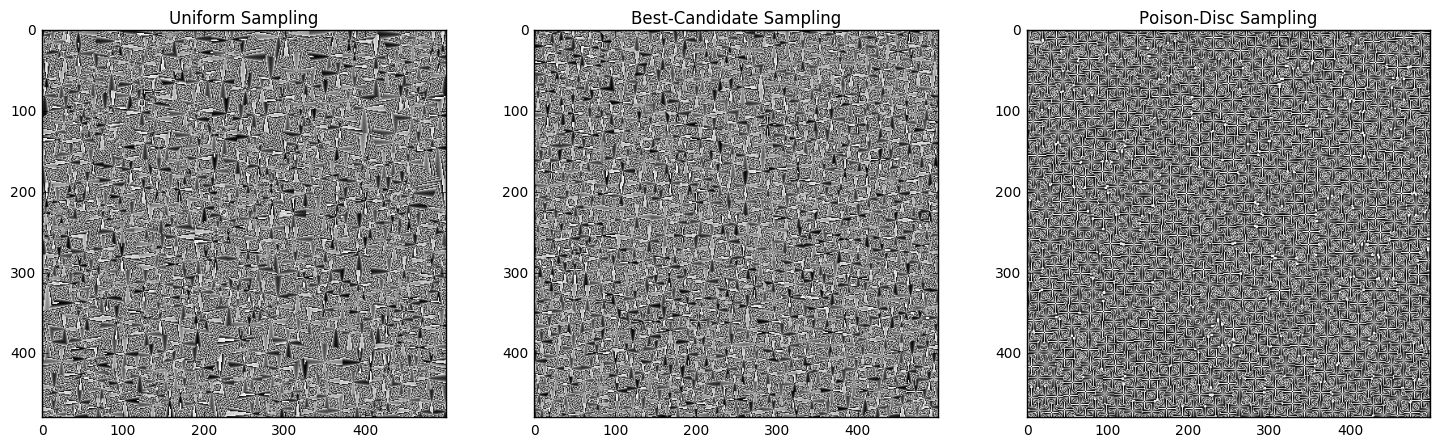

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))
axs[0].imshow(distmap_uni)
axs[0].set_title('Uniform Sampling')
axs[1].imshow(distmap_bc)
axs[1].set_title('Best-Candidate Sampling')
axs[2].imshow(distmap_pd)
axs[2].set_title('Poison-Disc Sampling')
plt.show()